Using PINNs to solve the transport equation with periodic boundary conditions

## **Setup**

In [1]:
# Set matplotlib for inline plots
%matplotlib inline
# Set matplotlib default font size\n",
import matplotlib as mpl
mpl.rc('font', size=15)
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## **SpacePeriodicNN Class**

In [3]:
"""
Fully connected feed-forward neural network 

Network takes two arguments (x, t)
Network's output will be L-periodic in x,
    where L is an argument of the NN
Currently, x is a scalar

NOTE: I ended up not using this class
      It was easier just to impose periodic
      boundary conditions as part of the loss
"""

class SpacePeriodicNN(nn.Module):
    
    def __init__(self, N_h, L=1, activation='tanh'):
        super().__init__()
        
        # Save network parameters
        self.N_in = 2 # 1 for time, 1 for cosine, 1 for sine
        self.N_out = 1
        self.L = L
        
        # Hidden layer size may be int or list of ints
        if isinstance(N_h, int):
            self.N_h = [N_h]
        else:
            self.N_h = N_h
        self.N_layers = len(self.N_h)
        
        # Select the activation function
        if activation == 'tanh':
            activation = nn.Tanh
        elif activation == 'relu':
            activation = nn.ReLU
        elif activation == 'sine':
            activation = torch.sin
        
        # Create the layers
        self.fcs = nn.Sequential(*[
            nn.Linear(self.N_in, self.N_h[0]), 
            activation()
        ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(self.N_h[i], self.N_h[i+1]),
                activation()
            ]) 
            for i in range(self.N_layers-1)]
        )
        self.fce = nn.Linear(self.N_h[-1], self.N_out)
        
        
    def forward(self, s):
        # Extract x, t
        t = s[:,0]
        x = s[:,1]
        # Convert x to cos(2 pi x / L) and sine(2 pi x / L) 
        cos = torch.cos(2 * torch.pi * x / self.L)
        sin = torch.sin(2 * torch.pi * x / self.L)
        # Concatenate the input into a single tensor
        nn_input = torch.vstack((t,x,cos,sin)).t()
        # Run the input through the network
        nn_out = self.fcs(nn_input)
        nn_out = self.fch(nn_out)
        nn_out = self.fce(nn_out)
        return nn_out

## **Basic Fully Connected NN**

In [2]:
"""
Fully connected feed-forward neural network 
"""

class FCNN(nn.Module):
    
    def __init__(self, N_h, N_in=2, N_out=1, activation='tanh'):
        super().__init__()
        
        # Save network parameters
        self.N_in = N_in
        self.N_out = N_out
        
        # Hidden layer size may be int or list of ints
        if isinstance(N_h, int):
            self.N_h = [N_h]
        else:
            self.N_h = N_h
        self.N_layers = len(self.N_h)
        
        # Select the activation function
        if activation == 'tanh':
            activation = nn.Tanh
        elif activation == 'relu':
            activation = nn.ReLU
        elif activation == 'sine':
            activation = torch.sin
        
        # Create the layers
        self.fcs = nn.Sequential(*[
            nn.Linear(self.N_in, self.N_h[0]), 
            activation()
        ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(self.N_h[i], self.N_h[i+1]),
                activation()
            ]) 
            for i in range(self.N_layers-1)]
        )
        self.fce = nn.Linear(self.N_h[-1], self.N_out)
        
        
    def forward(self, v):
        nn_out = self.fcs(v)
        nn_out = self.fch(nn_out)
        nn_out = self.fce(nn_out)
        return nn_out

## **Mesh Based Training Algorithm**

In [3]:
"""
Functions for computing derivatives of the network's output wrt its input
"""

def compute_u_v(v, u):
    """
    Computes u_v for the independent variable v and dependent variable u
    """
    return torch.autograd.grad(u, v, torch.ones_like(u), create_graph=True)[0]


def compute_u_vv(v, u_v):
    """
    Computes u_vv for the independent variable 'v' and dependent variable 'u' (not a parameter here)
    Must be given u_v, the partial derivative computed using compute_u_v()
    """
    return torch.autograd.grad(u_v, v, torch.ones_like(u_v), create_graph=True)[0]

In [4]:
"""
Function to generate mesh points on [0,1]^d x [0,T]
"""
def generate_mesh(nt, nx, d=1, T=1):
    """
     ARGUMENTS
        
        nt, nx   :   Ints. Number of temporal and spatial interior points
                     for the mesh, respectively
                     
        d        :   Int. Spatial dimension
        
        T        :   Float. Sets time domain to [0,T]
                     Default: 1
    
    RETURNS
    
        mesh_interior     :   (nt * nx^d, d+1)- Torch array of the interior of 
                                the spatiotemporal mesh (t != 0 and x_i \notin {0,1}
                                for all i)
                                
        mesh_boundary     :   (???, d+1) - Torch array of the spatial boundary
                                of the spatiotemporal mesh (x_i = 0 or x_i = 1
                                for some i = 1, ..., d)
                                
        mesh_t0           :   (nx*d, d+1)- Torch array of the t=0 mesh points
        
    
    NOTE: Currently only works with d=1. 
    TODO: Generalize to d > 1
    """
    t_vals = torch.linspace(0,T,steps=nt+2)
    x_vals = torch.linspace(0,1,steps=nx+2)
    
    # Create the interior mesh using meshgrid
    mesh = torch.meshgrid(
        [t_vals] + [x_vals] * d, indexing='ij'
    )
    
    # Break out the boundary, interior and t=0
    # Interior
    mesh_interior = torch.vstack([
        mesh_dim[1:,1:-1].ravel() 
        for mesh_dim in mesh
    ])
    # Boundary
    # Left boundary
    left = torch.vstack([
        mesh_dim[1:,0]
        for mesh_dim in mesh
    ])
    # Right boundary
    right = torch.vstack([
        mesh_dim[1:,-1]
        for mesh_dim in mesh
    ])
    # Combined
    mesh_boundary = torch.hstack((left,right))
    
    # t = 0
    mesh_t0 = torch.vstack([
        mesh_dim[0,:]
        for mesh_dim in mesh
    ])
    
    # Return
    return mesh_interior.t(), mesh_boundary.t(), mesh_t0.t()

In [5]:
def reconstruct_u_array(u_interior, u_bndry, u_t0):
    """
    Function to reconstruct the (n_t+2, n_x+2) solution
    given the solution at t=0, on the boundaries, and 
    inside the mesh
    """
    # Determine n_t and n_x
    n_x = u_t0.shape[0] - 2
    n_t = int(u_interior.shape[0] / n_x) - 1
    
    # Array to store the 2D array of the solution
    u = np.zeros((n_t+2,n_x+2))
    
    # Fill in the element of the array
    # t = 0
    u[0] = u_t0.reshape(n_x+2)
    # Boundary
    u[1:,0] = u_bndry[:u_bndry.shape[0]//2].reshape(-1)
    u[1:,-1] = u_bndry[u_bndry.shape[0]//2:].reshape(-1)
    # Interior
    u[1:,1:-1] = u_interior.reshape((n_t+1,n_x))
    
    # Return
    return u

In [6]:
def visualize_predictions(network, f_u_exact, n_t, n_x, T=1,
        plot_types=['exact', 'pred', 'res'], **kwargs
    ):
    """
    Function to generate a heatmap visualizing the NNs predictions
    on the mesh
    """
    # Create the mesh for visualization
    mesh_interior, mesh_bndry, mesh_t0 = generate_mesh(n_t, n_x, T=T)

    # Compute the NN's prediction
    with torch.no_grad():
        u_pred_bndry = network(mesh_bndry)
        u_pred_t0 = network(mesh_t0)
    if 'pde_res' in plot_types:
        mesh_interior.requires_grad = True
        u_pred_interior = network(mesh_interior)
    else:
        with torch.no_grad():
            u_pred_interior = network(mesh_interior)
    
    # Compute the PDE residuals
    if 'pde_res' in plot_types:
        f_pde = kwargs['f_pde']
        pde_res_vec = f_pde(mesh_interior, u_pred_interior).detach()
        # Reshape 
        pde_res = np.zeros((n_t+2,n_x+2))
        pde_res[1:,1:-1] = pde_res_vec.reshape(n_t+1,-1)
        # Detach the tensors - graph no longer needed
        mesh_interior = mesh_interior.detach()
        u_pred_interior = u_pred_interior.detach()
        
    # Reconstruct the NN's solution from the three pieces
    u_pred = reconstruct_u_array(
        u_pred_interior.detach(), u_pred_bndry, u_pred_t0
    )

    # Compute the exact solution
    u_exact_interior = f_u_exact(mesh_interior.detach())
    u_exact_bndry = f_u_exact(mesh_bndry)
    u_exact_t0 = f_u_exact(mesh_t0)
    u_exact = reconstruct_u_array(u_exact_interior, u_exact_bndry, u_exact_t0)

    # Heatmap visualization
    fig, axs  = plt.subplots(1,3,figsize=(15,5))
    for ax in axs:
        ax.set_xlabel('t')
        ax.set_ylabel('x')
    if 'suptitle' in kwargs:
        plt.suptitle(kwargs['suptitle'])

    vmxx_exact = np.abs(u_exact).max()
    vmxx_pred = np.abs(u_pred_interior.detach()).max()
    vmxx = max(vmxx_pred, vmxx_exact)
    
    # Subplots
    ims = []
    for plot_type, ax in zip(plot_types, axs):
        # Exact solution
        if plot_type == 'exact':
            ax.set_title('True solution')
            im = ax.imshow(
                u_exact.T, cmap='bwr_r', extent=(0,1,0,1),
                vmin=-vmxx, vmax=vmxx, origin='lower'
            )
        # Predicted solution
        elif plot_type == 'pred':
            ax.set_title('Predicted solution')
            im = ax.imshow(
                u_pred.T, cmap='bwr_r', extent=(0,1,0,1),
                vmin=-vmxx, vmax=vmxx, origin='lower'
            )
        # Residuals
        elif plot_type == 'res':
            residuals = u_exact - u_pred
            res_vmxx = np.abs(residuals).max()
            ax.set_title('Abs Val. Residuals')
            im = ax.imshow(
                np.abs(residuals).T, cmap='binary', extent=(0,1,0,1),
                origin='lower'
                # vmin=-res_vmxx, vmax=res_vmxx
            )
        # PDE Residuals
        elif plot_type == 'pde_res':
            res_vmxx = np.abs(pde_res).max()
            ax.set_title('Abs Val. PDE Residuals')
            im = ax.imshow(
                np.abs(pde_res).T, cmap='binary', extent=(0,1,0,1),
                origin='lower'
                # vmin=-res_vmxx, vmax=res_vmxx
            )
            
        # Save the heatmap
        ims.append(im)

    # Colorbors
    for i, im in enumerate(ims):
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    
    # Return the figure and axes
    return fig, axs

In [7]:
"""
Mesh-free training algorithm, specific to the SpacePeriodicNN class
"""
def train_on_mesh(network, f_pde, f_ic, nt, nx, 
        alpha=None, n_iters=1000, lr=1e-3, verbose=None, u_exact=None,
        make_pred_figs=None, fig_dir='./figures', fig_fname='transport',
        fig_mesh_size=None
    ):
    """
    ARGUMENTS
    
        network      :  FCN network to be trained
        
        f_pde        :  Callable. Function that computes the partial derivative based 
                        quantity that should be minimized
        
        f_ic         :  Callable. Function that computes the initial condition 
                        for the PDE that the NN is being trained to solve
                        
        nt, nx       :  Ints. Number of temporal and spatial interior points
                        for the mesh, respectively
                        
        alpha        :  Tuple. Sets the scaling of the three
                        terms in the loss function
                        
                        L = alpha[0] L_pde + alpha[1] * L_ic

                        Default: [1,1]
        
        n_iters      :  Number of training iterations
                        Default: 1000
                        
        lr           :  Learning rate
                        Default: 1e-3
        
        u_exact      :  None or Callable function that computes the exact
                        solution given any point in the domain
                        Default: None
                        
        make_pred_figs      :   None or Int.
                                Set to Int to set the rate at which to 
                                    generate and save figures visualizing 
                                    the NNs predictions and errors. 
                                    Requires 'u_exact' to not be None
                                Set to None to not create such figures.
                                Default: None
                                    
        fig_dir      :  String. Path to directory where training visualizations
                        should be saved.
                        Default: './figures'
        
        fig_fname    :  String. Figures generated by this method will have
                        the filenames of the form 'save_fig_fname_iter%d.png'
                        
        fig_mesh_size   : Tuple (n_t_viz, n_x_viz) setting the mesh size used when
                          generating the visualizations of the networks predictions.
                          Set to None to use (n_t, n_x)
                          Default: None
                            
    RETURNS
    
        L_pde    
        
        L_bc
        
        L_ic
        
        L_train
        
        L2_err
    """
    
    # Loss coefs alpha[i]
    if alpha is None:
        alpha = [1,1]
    alpha = np.array(alpha, dtype=float)
    
    # Create the optimizer
    optimizer = torch.optim.Adam(network.parameters(),lr=lr)
    
    # Object to compute MSE loss
    mse_loss = nn.MSELoss()
    
    # Arrays to store the losses
    L_pde = np.zeros(n_iters)    # PDE loss
    L_bc = np.zeros(n_iters)     # Initial condition loss
    L_ic = np.zeros(n_iters)     # Initial condition loss
    L_train = np.zeros(n_iters)  # Overall training loss
    if u_exact is not None:
        L2_err = np.zeros(n_iters)  # L2-error on exact solution
        
    # Create the mesh
    mesh_interior, mesh_boundary, mesh_t0 = generate_mesh(nt, nx)
    # Set the interior points to requires grad
    mesh_interior.requires_grad = True
    # Compute the number of boundary points
    n_bndry_pts = mesh_boundary.shape[0]
    # Compute the initial condition at the mesh points
    u_exact_t0 = f_ic(mesh_t0)
    # Compute the exact solution at the mesh points
    # if the function for computed the exact soln is
    # provided
    if u_exact is not None:
        u_exact_interior = u_exact(mesh_interior.detach())
        
    # Mesh figsize
    if make_pred_figs is not None:
        if fig_mesh_size is None:
            n_t_viz, n_x_viz = (n_t, n_x)
        else:
            n_t_viz, n_x_viz = fig_mesh_size
    
    # Training loop
    for i in range(n_iters):
        # Clear the parameter gradients
        optimizer.zero_grad()
        
        # Initial condition loss
        # Compute the network's predictons for mesh_t0
        u_net_t0 = network(mesh_t0)
        # Initial condition loss
        L_ic_i = mse_loss(u_exact_t0, u_net_t0) 
        L_ic[i] = L_ic_i.detach() 
        
        # Periodic BC Loss
        u_net_bndry = network(mesh_boundary)
        u_net_left_bndry = u_net_bndry[:n_bndry_pts//2]
        u_net_right_bndry = u_net_bndry[n_bndry_pts//2:]
        L_bc_i = mse_loss(u_net_left_bndry, u_net_right_bndry)
        L_bc[i] = L_bc_i.detach() 
        
        # PDE loss
        # Compute the NN's output at the interior points
        u_net_interior = network(mesh_interior)
        # Compute the NN's PDE loss
        L_pde_i = f_pde(mesh_interior, u_net_interior).square().mean()
        L_pde[i] = L_pde_i.detach()
        
        # L2 Error on exact solution
        if u_exact is not None:
            # Compute the network's L2 error on these points
            L2_err[i] = np.sqrt(
                mse_loss(u_exact_interior, u_net_interior.detach())
            )
        
        # Overall loss
        L_train_i = alpha[0] * L_pde_i + alpha[1] * L_bc_i + alpha[2] * L_ic_i
        L_train[i] = L_train_i.detach()
        
        # Update the network's parameter
        L_train_i.backward()
        optimizer.step()
        
        # Progress update
        if verbose and ((i == 0) or ((i+1) % verbose) == 0):
            fmt_str = 'Iter %d/%d, Losses: PDE=%.2e  BC=%.2e  IC=%.2e  TR=%.2e'
            msg = fmt_str % (i+1, n_iters, L_pde_i, L_bc_i, L_ic_i, L_train_i)
            if u_exact is not None:
                msg += ' L2-err: %.2e' % L2_err[i]
            print(msg)
            
        # Save visualization of network predictions
        if make_pred_figs and ((i == 0) or ((i+1) % make_pred_figs) == 0):
            # Make the figure
            fig, axs = visualize_predictions(
                network, u_exact, n_t_viz, n_x_viz,
                suptitle='Training Iteration %d' % (i+1),
                f_pde=f_pde, plot_types=['pred', 'pde_res', 'res']
            )
            # Save to file
            plt.savefig(
                '%s/%s_iter%d.png' % (fig_dir, fig_fname, i+1),
                facecolor='white', transparent=False
            )
            # Close the figure
            plt.close()
            
            
    # Return the loss arrays as np arrays
    losses = [L_pde, L_bc, L_ic, L_train]
    if u_exact is not None:
        losses.append(L2_err)
    return losses

## **Mesh Based Training Experiment**

In [8]:
def f_pde_transport(v, u, a=1):
    """
    PDE loss associated with the transport equation
    u_t + a u_x = 0
    
    Only works for d = 1 right now
    
    ARGUMENTS
    
        v    :   (# points, d+1)-Torch tensor of (t[i], x[i]) pairs where
                     v[i,0] = t[i] and s[i,1:] = x[i]
                     
        u    :   (# points,)-Torch tensor of u[i] = u(t[i], x[i])
        
        a    :   (d,)-Torch tensor. The transport velocity
                 Default: a = [1, 1, ..., d]^t
        
    RETURNS
    
       the PDE loss ... IDK what to call it
    """
    # Set the Transport velocity
    if a is None:
        a = torch.ones(v.shape[1]-1)
    
    # Compute u_t
    u_v = compute_u_v(v, u)
    # Extract u_t and u_x
    u_t = u_v[:,0]
    u_x = u_v[:,1]
    
    # Compute Q
    return u_t + a * u_x



def f_ic_basic_transport(s):
    """
    Basic IC for the transport equation
    Only works for d = 1
    
    s = (t, x)
    """
    return torch.cos(2 * torch.pi * s[:,1]).view(-1,1)


def u_exact_basic_transport(s):
    """
    Exact solution to the transport equation
    
                u_t + u_x = 0
    
    on [0,1] x [0,1] with the basic initial 
    condition
    
            u(x,0) = cos(2 pi x)
    """
    x_t = s[:,1] - s[:,0]
    return torch.cos(2 * torch.pi * x_t).view(-1,1)

In [23]:
"""
------------------------------------------------------------------------
                                The TEST
------------------------------------------------------------------------
"""

"""
Parameters
"""

# Network parameters
N_h = [64,64]

# Training parameters
nt = 10
nx = 5
alpha = np.array([1,1.5,1])       # Relative importance of pde / bc / ic loss
n_iters = 1200     # Number of training iterations
lr = 1e-3          # Learning rate
verbose=30

# Visualization parameters (during training)
make_pred_figs=None # 15
fig_dir='./figures/transport'
fig_fname='transport'
fig_mesh_size=(50,50)

"""
Setup
"""
# Set the random seed for reproducibility
seed = np.random.randint(1e6) # 913988
print('Random seed:', seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the network
network = FCNN(N_h=N_h)

# Clear the figure directory
for f in os.listdir(fig_dir):
    if f.startswith(fig_fname):
        os.remove(os.path.join(fig_dir, f))

"""
Training Loop
"""
L_pde, L_bc, L_ic, L_train, L2_err = train_on_mesh(network,
        lambda pts,u: f_pde_transport(pts, u), f_ic_basic_transport, 
        nt, nx, alpha, n_iters, lr, verbose, u_exact_basic_transport,
        make_pred_figs, fig_dir, fig_fname, fig_mesh_size
    )

Random seed: 646773
Iter 1/1200, Losses: PDE=1.04e-02  BC=2.01e-02  IC=6.09e-01  TR=6.49e-01 L2-err: 7.18e-01
Iter 30/1200, Losses: PDE=1.15e-03  BC=5.04e-05  IC=5.50e-01  TR=5.51e-01 L2-err: 7.19e-01
Iter 60/1200, Losses: PDE=4.84e-04  BC=1.97e-05  IC=5.42e-01  TR=5.43e-01 L2-err: 7.20e-01
Iter 90/1200, Losses: PDE=3.32e-03  BC=1.86e-04  IC=5.29e-01  TR=5.32e-01 L2-err: 7.22e-01
Iter 120/1200, Losses: PDE=1.16e-02  BC=1.03e-03  IC=5.06e-01  TR=5.19e-01 L2-err: 7.24e-01
Iter 150/1200, Losses: PDE=1.27e-02  BC=1.50e-03  IC=4.77e-01  TR=4.92e-01 L2-err: 7.25e-01
Iter 180/1200, Losses: PDE=2.12e-02  BC=2.75e-03  IC=4.15e-01  TR=4.40e-01 L2-err: 7.13e-01
Iter 210/1200, Losses: PDE=2.37e-02  BC=1.03e-02  IC=3.25e-01  TR=3.64e-01 L2-err: 6.86e-01
Iter 240/1200, Losses: PDE=3.36e-02  BC=2.98e-02  IC=2.26e-01  TR=3.04e-01 L2-err: 6.54e-01
Iter 270/1200, Losses: PDE=3.46e-02  BC=3.49e-02  IC=1.76e-01  TR=2.63e-01 L2-err: 6.26e-01
Iter 300/1200, Losses: PDE=4.02e-02  BC=3.01e-02  IC=1.36e-01  TR

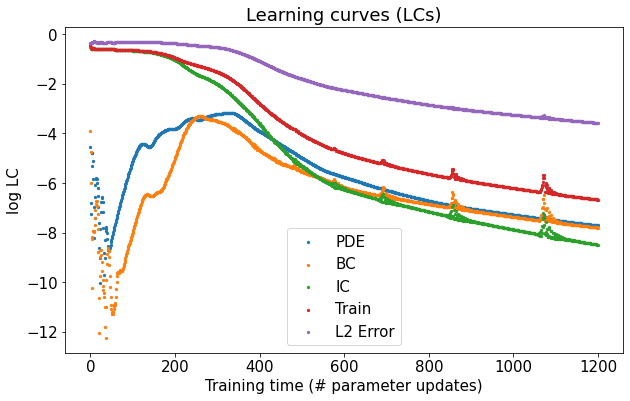

In [24]:
"""
Plot the learning curves
"""
plt.figure(figsize=(10,6))
plt.title('Learning curves (LCs)')
plt.xlabel('Training time (# parameter updates)')
plt.ylabel('log LC')

LCs = [L_pde, L_bc, L_ic, L_train, L2_err]
labels = ['PDE', 'BC', 'IC', 'Train', 'L2 Error']
sample_rate = 1
times = sample_rate * np.arange(LCs[0].shape[0] / sample_rate)
for lc,label in zip(LCs, labels):
    plt.scatter(times, np.log(lc[::sample_rate]), label=label, s=5)
plt.legend()
plt.savefig('%s/learning_curves.png' % fig_dir)
plt.show()

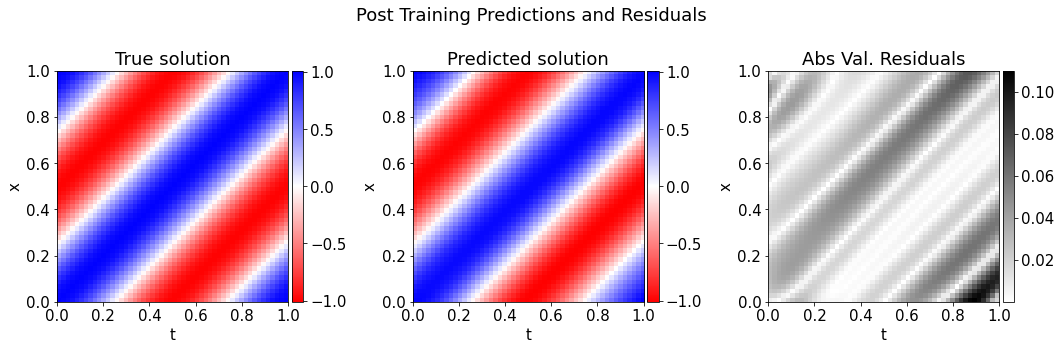

In [25]:
"""
Post training visualization
"""
fig, axs = visualize_predictions(
    network, u_exact_basic_transport, n_t=50, n_x=50, T=1,
    suptitle='Post Training Predictions and Residuals'
)
plt.show()

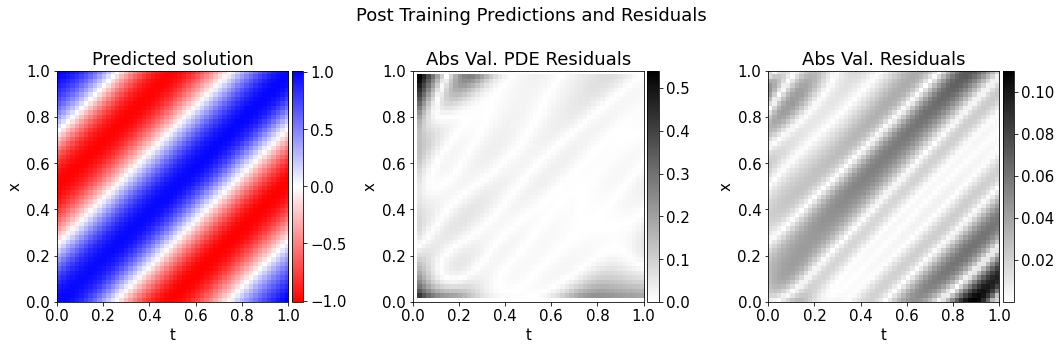

In [26]:
fig, axs = visualize_predictions(
    network, u_exact_basic_transport, n_t=50, n_x=50, T=1,
    suptitle='Post Training Predictions and Residuals',
    plot_types = ['pred', 'pde_res', 'res'],
    f_pde = f_pde_transport
)
plt.show()

In [184]:
"""
Number of parameters in the model
"""
num_params = 0
for param in network.parameters():
    num_params += param.numel()
print('# parameters:', num_params)

# parameters: 4417


In [179]:
50 * 20

1000

## **Mesh Free Training Algorithm**

In [10]:
"""
Functions for randomly sampling the spatiotemporal domain

TODO (future): add option to control sampling distribution
"""

def sample_t0_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from {0} x [0,1]^d
    where each x_ij ~ U([0,1])
    """
    points = torch.rand(size=(n_pts,d+1))
    points[:,0] = 0 # set time dimension to zero
    return points


def sample_boundary_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from the spactial 
    boundary of [0,T] x [0,1]^d. In particular,
    
        t_i  ~ U(0,T),
        x_ij ~ U(0,1), and 
        x_ij = 0 or 1 for one randomly selected j
    """
    points = torch.rand(size=(n_pts,d+1))
    # Randomly select a spatial index to be set to 
    # 0 or 1 to enforce that this point is on the boundary
    bndy_inds = torch.randint(low=1,high=d+1,size=(n_pts,))
    bndy_vals = torch.randint(low=0,high=2,size=(n_pts,))
    points[torch.arange(n_pts),bndy_inds] = bndy_vals.float()
    # Rescale time
    points[:,0] *= T
    return points


def sample_boundary_pairs(n_pairs, d, T=1):
    """
    Samples 'n_pairs' pairs of points (t_i, x_i)
    (t_i, x'_i) from the spatial boundary of the 
    [0,T] x [0,1]^d. In particular,
    
        t_i  ~ U(0,T),
        x_ij, x'_ij ~ U(0,1), and 
        x_ij = 0 and x'_ij 1 for one randomly selected j
    """
    bndry_pts = torch.rand(size=(n_pairs,d+1))
    # Randomly select a spatial index to be set to 
    # 0 or 1 to enforce that this point is on the boundary
    bndry_inds = torch.randint(low=1,high=d+1,size=(n_pairs,))
    # Set the values at the selected boundary indexes to 0 
    # for the 'bndry_pts' array
    bndry_pts[torch.arange(n_pairs),bndry_inds] = 0
    # Rescale time
    bndry_pts[:,0] *= T
    # Duplicate 'points' and set the values at the selected 
    # boundary indexes to 0 for the duplicate array
    opposite_bndry_pts = bndry_pts.clone()
    opposite_bndry_pts[torch.arange(n_pairs),bndry_inds] = 1
    # Return the pairs
    return bndry_pts, opposite_bndry_pts


def sample_interior_points(n_pts, d, T=1):
    """
    Samples 'n_pts' points (t_i, x_i) from (0,T) x (0,1)^d
    with t_i  ~ U(0,T) and x_ij ~ U(0,1)
    """
    points = torch.rand(size=(n_pts,d+1))
    points[:,0] *= T  # Rescale time
    return points

In [11]:
"""
Mesh-free training algorithm for periodic boundary conditions
"""
def train_mesh_free(network, f_pde, f_ic, n_pde_pts, n_bc_pts, n_ic_pts,
        alpha=None, n_iters=1000, lr=1e-3, verbose=None, u_exact=None,
        make_pred_figs=None, fig_dir='./figures/mesh-free', fig_fname='transport',
        fig_mesh_size=None
    ):
    """
    ARGUMENTS
    
        network      :  FCN network to be trained
        
        f_pde        :  Callable. Function that computes the partial derivative based 
                        quantity that should be minimized
        
        f_ic         :  Callable. Function that computes the initial condition 
                        for the PDE that the NN is being trained to solve
                        
        n_pde_pts    :  Number of interior mesh points used to compute
                        the PDE loss on each iteration
                        Default: 2^(d+1), where d is # of spatial dimensions
        
        n_bc_pts     :  Number of boundary points used to compute the 
                        boundary condition loss on each iterations
                        Default: 2^d
        
        n_ic_pts     :  Number of points used to the compute the initial
                        condition loss on each iterations
                        Default: 2^d
                        
        alpha        :  Tuple. Sets the scaling of the three
                        terms in the loss function
                        
                        L = alpha[0] L_pde + alpha[1] * L_ic

                        Default: [1,1]
        
        n_iters      :  Number of training iterations
                        Default: 1000
                        
        lr           :  Learning rate
                        Default: 1e-3
        
        u_exact      :  None or Callable function that computes the exact
                        solution given any point in the domain
                        Default: None
                        
        make_pred_figs      :   None or Int.
                                Set to Int to set the rate at which to 
                                    generate and save figures visualizing 
                                    the NNs predictions and errors. 
                                    Requires 'u_exact' to not be None
                                Set to None to not create such figures.
                                Default: None
                                    
        fig_dir      :  String. Path to directory where training visualizations
                        should be saved.
                        Default: './figures'
        
        fig_fname    :  String. Figures generated by this method will have
                        the filenames of the form 'save_fig_fname_iter%d.png'
                        
        fig_mesh_size   : Tuple (n_t_viz, n_x_viz) setting the mesh size used when
                          generating the visualizations of the networks predictions.
                          Set to None to use (n_t, n_x)
                          Default: None
                            
    RETURNS
    
        L_pde    
        
        L_bc
        
        L_ic
        
        L_train
        
        L2_err
    """
    d = 1 # Method works only for d = 1 right now
    
    # Number of pde / boundary/ t0 training points
    if n_pde_pts is None:
        n_pde_pts = 2 ** (d+1)
    if n_bc_pts is None:
        n_bc_pts = 2 ** d
    if n_ic_pts is None:
        n_ic_pts = 2 ** d
    
    # Loss coefs alpha[i]
    if alpha is None:
        alpha = np.array([1,1,1]) / 3
    alpha = np.array(alpha, dtype=float)
    
    # Create the optimizer
    optimizer = torch.optim.Adam(network.parameters(),lr=lr)
    
    # Object to compute MSE loss
    mse_loss = nn.MSELoss()
    
    # Arrays to store the losses
    L_pde = np.zeros(n_iters)    # PDE loss
    L_bc = np.zeros(n_iters)     # Initial condition loss
    L_ic = np.zeros(n_iters)     # Initial condition loss
    L_train = np.zeros(n_iters)  # Overall training loss
    if u_exact is not None:
        L2_err = np.zeros(n_iters)  # L2-error on exact solution
    
    # TODO: figure out what to do in terms of the L2 error
    
    # Training loop
    for i in range(n_iters):
        # Clear the parameter gradients
        optimizer.zero_grad()
        
        # Initial condition loss
        # Generate 'n_ic_pts' points with t = 0
        mesh_t0 = sample_t0_points(n_ic_pts, d)
        # Compute the initial condition at these points
        u_exact_t0 = f_ic(mesh_t0)
        # Compute the network's predictons for mesh_t0
        u_net_t0 = network(mesh_t0)
        # Initial condition loss
        L_ic_i = mse_loss(u_exact_t0, u_net_t0) 
        L_ic[i] = L_ic_i.detach() 
        
        # Periodic BC Loss
        # Generate 'n_bc_pts' points from the spatial boundary
        bndry_pts, opp_bndry_pts = sample_boundary_pairs(n_bc_pts, d)
        u_net_bndry = network(bndry_pts)
        u_net_opp_bndry = network(opp_bndry_pts)
        L_bc_i = mse_loss(u_net_bndry, u_net_opp_bndry)
        L_bc[i] = L_bc_i.detach() 
        
        # PDE loss
        # Generate 'n_pde_pts' points from the interior of the 
        # spatial temporal domain
        mesh_interior = sample_interior_points(n_pde_pts, d)
        mesh_interior.requires_grad = True
        # Compute the NN's output at the interior points
        u_net_interior = network(mesh_interior)
        # Compute the NN's PDE loss
        L_pde_i = f_pde(mesh_interior, u_net_interior).square().mean()
        L_pde[i] = L_pde_i.detach()
        
        # L2 Error on exact solution
        if u_exact is not None:
            # Compute the network's L2 error on these points
            L2_err[i] = np.sqrt(
                mse_loss(u_exact_interior, u_net_interior.detach())
            )
        
        # Overall loss
        L_train_i = alpha[0] * L_pde_i + alpha[1] * L_bc_i + alpha[2] * L_ic_i
        L_train[i] = L_train_i.detach()
        
        # Update the network's parameter
        L_train_i.backward()
        optimizer.step()
        
        # Progress update
        if verbose and ((i == 0) or ((i+1) % verbose) == 0):
            fmt_str = 'Iter %d/%d, Losses: PDE=%.2e  BC=%.2e  IC=%.2e  TR=%.2e'
            msg = fmt_str % (i+1, n_iters, L_pde_i, L_bc_i, L_ic_i, L_train_i)
            if u_exact is not None:
                msg += ' L2-err: %.2e' % L2_err[i]
            print(msg)
            
        # Save visualization of network predictions
        if make_pred_figs and ((i == 0) or ((i+1) % make_pred_figs) == 0):
            # Make the figure
            fig, axs = visualize_predictions(
                network, u_exact, n_t_viz, n_x_viz,
                suptitle='Training Iteration %d' % (i+1),
                f_pde=f_pde, plot_types=['pred', 'pde_res', 'res']
            )
            # Save to file
            plt.savefig(
                '%s/%s_iter%d.png' % (fig_dir, fig_fname, i+1),
                facecolor='white', transparent=False
            )
            # Close the figure
            plt.close()
            
            
    # Return the loss arrays as np arrays
    losses = [L_pde, L_bc, L_ic, L_train]
    if u_exact is not None:
        losses.append(L2_err)
    return losses

In [14]:
"""
------------------------------------------------------------------------
                                The TEST
------------------------------------------------------------------------
"""

"""
Parameters
"""

# Network parameters
N_h = [64,64]

# Training parameters
n_pde_pts = 100   # Number of training points for pde / bc / ic
n_bc_pts = 20
n_ic_pts = 30    
alpha = np.array([1,1,1])       # Relative importance of pde / bc / ic loss
n_iters = 5*1000     # Number of training iterations
lr = 1e-3          # Learning rate
verbose=n_iters//30

# Visualization parameters (during training)
make_pred_figs=None
fig_dir='./figures/transport'
fig_fname='transport'
fig_mesh_size=(50,50)

"""
Setup
"""
# Set the random seed for reproducibility
seed = np.random.randint(1e6) # 913988
print('Random seed:', seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the network
network = FCNN(N_h=N_h)

# Clear the figure directory
# for f in os.listdir(fig_dir):
#     if f.startswith(fig_fname):
#         os.remove(os.path.join(fig_dir, f))

"""
Training Loop
"""
L_pde, L_bc, L_ic, L_train = train_mesh_free(network,
        f_pde_transport, f_ic_basic_transport, n_pde_pts, n_bc_pts, n_ic_pts,
        alpha, n_iters, lr, verbose, None, #u_exact_basic_transport,
        make_pred_figs, fig_dir, fig_fname, fig_mesh_size
    )

Random seed: 442040
Iter 1/5000, Losses: PDE=2.93e-03  BC=2.90e-02  IC=5.59e-01  TR=5.91e-01
Iter 166/5000, Losses: PDE=3.26e-03  BC=1.27e-04  IC=5.40e-01  TR=5.43e-01
Iter 332/5000, Losses: PDE=7.26e-03  BC=3.76e-04  IC=3.77e-01  TR=3.85e-01
Iter 498/5000, Losses: PDE=7.89e-03  BC=1.86e-03  IC=4.62e-01  TR=4.72e-01
Iter 664/5000, Losses: PDE=1.21e-02  BC=1.56e-03  IC=4.20e-01  TR=4.33e-01
Iter 830/5000, Losses: PDE=1.11e-02  BC=3.29e-02  IC=2.68e-01  TR=3.12e-01
Iter 996/5000, Losses: PDE=2.74e-02  BC=5.12e-02  IC=1.38e-01  TR=2.17e-01
Iter 1162/5000, Losses: PDE=2.67e-02  BC=5.82e-02  IC=9.82e-02  TR=1.83e-01
Iter 1328/5000, Losses: PDE=2.56e-02  BC=5.70e-02  IC=8.23e-02  TR=1.65e-01
Iter 1494/5000, Losses: PDE=3.21e-02  BC=2.58e-02  IC=6.12e-02  TR=1.19e-01
Iter 1660/5000, Losses: PDE=2.28e-02  BC=3.21e-02  IC=5.64e-02  TR=1.11e-01
Iter 1826/5000, Losses: PDE=1.75e-02  BC=2.13e-02  IC=4.23e-02  TR=8.11e-02
Iter 1992/5000, Losses: PDE=9.14e-03  BC=1.37e-02  IC=3.12e-02  TR=5.41e-02
I

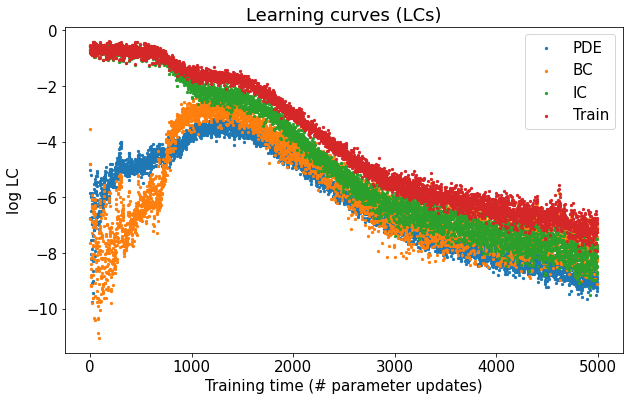

In [16]:
"""
Plot the learning curves
"""
plt.figure(figsize=(10,6))
plt.title('Learning curves (LCs)')
plt.xlabel('Training time (# parameter updates)')
plt.ylabel('log LC')

LCs = [L_pde, L_bc, L_ic, L_train]
labels = ['PDE', 'BC', 'IC', 'Train']
sample_rate = 1
times = sample_rate * np.arange(LCs[0].shape[0] / sample_rate)
for lc,label in zip(LCs, labels):
    plt.scatter(times, np.log(lc[::sample_rate]), label=label, s=5)
plt.legend()
plt.savefig('%s/learning_curves.png' % fig_dir)
plt.show()

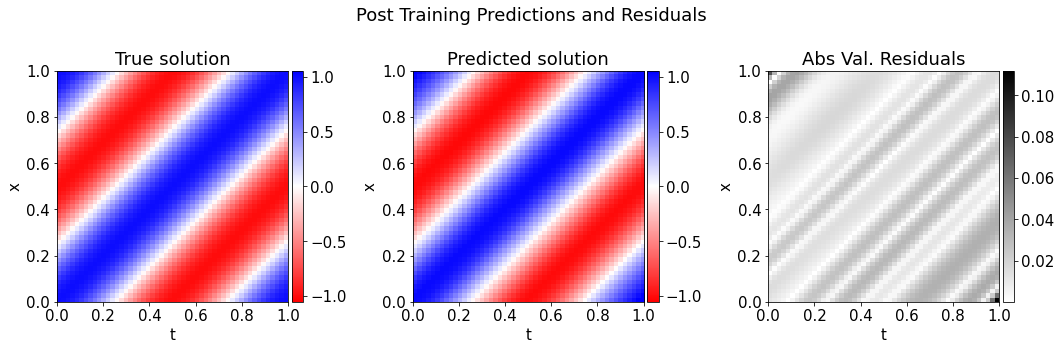

In [17]:
"""
Post training visualization
"""
fig, axs = visualize_predictions(
    network, u_exact_basic_transport, n_t=50, n_x=50, T=1,
    suptitle='Post Training Predictions and Residuals'
)
plt.show()

## **Mesh Free Training + Error-Based Sampling**

In [ ]:
"""
Mesh-free training algorithm for periodic boundary conditions
"""
def train_mesh_free_error_based_sampling(
        network, f_pde, f_ic, n_pde_pts, n_bc_pts, n_ic_pts,
        alpha=None, n_iters=1000, lr=1e-3, verbose=None, u_exact=None,
        make_pred_figs=None, fig_dir='./figures/mesh-free', fig_fname='transport',
        fig_mesh_size=None
    ):
    """
    ARGUMENTS
    
        network      :  FCN network to be trained
        
        f_pde        :  Callable. Function that computes the partial derivative based 
                        quantity that should be minimized
        
        f_ic         :  Callable. Function that computes the initial condition 
                        for the PDE that the NN is being trained to solve
                        
        n_pde_pts    :  Number of interior mesh points used to compute
                        the PDE loss on each iteration
                        Default: 2^(d+1), where d is # of spatial dimensions
        
        n_bc_pts     :  Number of boundary points used to compute the 
                        boundary condition loss on each iterations
                        Default: 2^d
        
        n_ic_pts     :  Number of points used to the compute the initial
                        condition loss on each iterations
                        Default: 2^d
                        
        alpha        :  Tuple. Sets the scaling of the three
                        terms in the loss function
                        
                        L = alpha[0] L_pde + alpha[1] * L_ic

                        Default: [1,1]
        
        n_iters      :  Number of training iterations
                        Default: 1000
                        
        lr           :  Learning rate
                        Default: 1e-3
        
        u_exact      :  None or Callable function that computes the exact
                        solution given any point in the domain
                        Default: None
                        
        make_pred_figs      :   None or Int.
                                Set to Int to set the rate at which to 
                                    generate and save figures visualizing 
                                    the NNs predictions and errors. 
                                    Requires 'u_exact' to not be None
                                Set to None to not create such figures.
                                Default: None
                                    
        fig_dir      :  String. Path to directory where training visualizations
                        should be saved.
                        Default: './figures'
        
        fig_fname    :  String. Figures generated by this method will have
                        the filenames of the form 'save_fig_fname_iter%d.png'
                        
        fig_mesh_size   : Tuple (n_t_viz, n_x_viz) setting the mesh size used when
                          generating the visualizations of the networks predictions.
                          Set to None to use (n_t, n_x)
                          Default: None
                            
    RETURNS
    
        L_pde    
        
        L_bc
        
        L_ic
        
        L_train
        
        L2_err
    """
    d = 1 # Method works only for d = 1 right now
    
    # Number of pde / boundary/ t0 training points
    if n_pde_pts is None:
        n_pde_pts = 2 ** (d+1)
    if n_bc_pts is None:
        n_bc_pts = 2 ** d
    if n_ic_pts is None:
        n_ic_pts = 2 ** d
    
    # Loss coefs alpha[i]
    if alpha is None:
        alpha = np.array([1,1,1]) / 3
    alpha = np.array(alpha, dtype=float)
    
    # Create the optimizer
    optimizer = torch.optim.Adam(network.parameters(),lr=lr)
    
    # Object to compute MSE loss
    mse_loss = nn.MSELoss()
    
    # Arrays to store the losses
    L_pde = np.zeros(n_iters)    # PDE loss
    L_bc = np.zeros(n_iters)     # Initial condition loss
    L_ic = np.zeros(n_iters)     # Initial condition loss
    L_train = np.zeros(n_iters)  # Overall training loss
    if u_exact is not None:
        L2_err = np.zeros(n_iters)  # L2-error on exact solution
    
    # TODO: figure out what to do in terms of the L2 error
    
    # Training loop
    for i in range(n_iters):
        # Clear the parameter gradients
        optimizer.zero_grad()
        
        # Sampling
        # Case 1: No Errors to base Sampling on
        if i == 0:
            # Generate 'n_ic_pts' points with t = 0
            mesh_t0 = sample_t0_points(n_ic_pts, d)
            # Generate 'n_bc_pts' points from the spatial boundary
            bndry_pts, opp_bndry_pts = sample_boundary_pairs(n_bc_pts, d)
             # Generate 'n_pde_pts' points from the interior of the 
            # spatial temporal domain
            mesh_interior = sample_interior_points(n_pde_pts, d)
            mesh_interior.requires_grad = True
        # Case 2: Have Errors to base sampling on
        else:
            # TODO: finish
        
        # Initial condition loss
        
        # Compute the initial condition at these points
        u_exact_t0 = f_ic(mesh_t0)
        # Compute the network's predictons for mesh_t0
        u_net_t0 = network(mesh_t0)
        # Initial condition loss
        L_ic_i = mse_loss(u_exact_t0, u_net_t0) 
        L_ic[i] = L_ic_i.detach() 
        
        # Periodic BC Loss
        
        u_net_bndry = network(bndry_pts)
        u_net_opp_bndry = network(opp_bndry_pts)
        L_bc_i = mse_loss(u_net_bndry, u_net_opp_bndry)
        L_bc[i] = L_bc_i.detach() 
        
        # PDE loss
       
        # Compute the NN's output at the interior points
        u_net_interior = network(mesh_interior)
        # Compute the NN's PDE loss
        L_pde_i = f_pde(mesh_interior, u_net_interior).square().mean()
        L_pde[i] = L_pde_i.detach()
        
        # L2 Error on exact solution
        if u_exact is not None:
            # Compute the network's L2 error on these points
            L2_err[i] = np.sqrt(
                mse_loss(u_exact_interior, u_net_interior.detach())
            )
        
        # Overall loss
        L_train_i = alpha[0] * L_pde_i + alpha[1] * L_bc_i + alpha[2] * L_ic_i
        L_train[i] = L_train_i.detach()
        
        # Update the network's parameter
        L_train_i.backward()
        optimizer.step()
        
        # Progress update
        if verbose and ((i == 0) or ((i+1) % verbose) == 0):
            fmt_str = 'Iter %d/%d, Losses: PDE=%.2e  BC=%.2e  IC=%.2e  TR=%.2e'
            msg = fmt_str % (i+1, n_iters, L_pde_i, L_bc_i, L_ic_i, L_train_i)
            if u_exact is not None:
                msg += ' L2-err: %.2e' % L2_err[i]
            print(msg)
            
        # Save visualization of network predictions
        if make_pred_figs and ((i == 0) or ((i+1) % make_pred_figs) == 0):
            # Make the figure
            fig, axs = visualize_predictions(
                network, u_exact, n_t_viz, n_x_viz,
                suptitle='Training Iteration %d' % (i+1),
                f_pde=f_pde, plot_types=['pred', 'pde_res', 'res']
            )
            # Save to file
            plt.savefig(
                '%s/%s_iter%d.png' % (fig_dir, fig_fname, i+1),
                facecolor='white', transparent=False
            )
            # Close the figure
            plt.close()
            
            
    # Return the loss arrays as np arrays
    losses = [L_pde, L_bc, L_ic, L_train]
    if u_exact is not None:
        losses.append(L2_err)
    return losses